In [428]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
%load_ext autoreload
%autoreload 2

from settings import *
from url_helpers import analyze_url
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from math import sqrt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [429]:
figures = conf['aux_dir']+'figure-eight/'
trust_thr = .45

In [430]:
df = pd.read_csv(figures+'tobacco-crowd.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'crowd (w/o indicators)'})
df = df[df._trust > trust_thr][['article', 'crowd (w/o indicators)']]
df.article = df.article.apply(lambda x: x.replace('https://', 'http://'))
print(df.shape)
df_crowd = df.groupby('article').mean()

(85, 2)


In [431]:
df = pd.read_csv(figures+'tobacco-crowd-ind.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'crowd (w/ indicators)'})
df = df[df._trust > trust_thr][['article', 'crowd (w/ indicators)']]
df.article = df.article.apply(lambda x: x.replace('https://', 'http://'))
print(df.shape)
df_crowd_ind = df.groupby('article').mean()

(65, 2)


In [432]:
df1 = pd.read_csv(figures+'tobacco-Andreu.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert1'}).sort_values(by='article')
df2 = pd.read_csv(figures+'tobacco-Aina.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert2'}).sort_values(by='article').drop('article', axis=1)
df_exp = pd.concat([df1,df2], axis=1)[['article', 'expert1', 'expert2']]
df_exp.article = df_exp.article.apply(lambda x: x.replace('https://', 'http://'))
df_exp['diff'] = abs(df_exp['expert1'] - df_exp['expert2'])
df_exp['expert'] = (df_exp['expert1'] + df_exp['expert2'])/2
df_exp = df_exp.set_index('article')
print(cohen_kappa_score(df_exp['expert1'], df_exp['expert2']))


0.09090909090909094


In [433]:
df = df_crowd.join(df_exp).join(df_crowd_ind).reset_index()

In [434]:
print(sqrt(mean_squared_error(df[df['diff']==0]['crowd (w/o indicators)'], df[df['diff']==0]['expert'])))
print(sqrt(mean_squared_error(df[df['diff']==0]['crowd (w/ indicators)'], df[df['diff']==0]['expert'])))
print()
print(sqrt(mean_squared_error(df[df['diff']==1]['crowd (w/o indicators)'], df[df['diff']==1]['expert'])))
print(sqrt(mean_squared_error(df[df['diff']==1]['crowd (w/ indicators)'], df[df['diff']==1]['expert'])))
print()
print(sqrt(mean_squared_error(df[df['diff']>1]['crowd (w/o indicators)'], df[df['diff']>1]['expert'])))
print(sqrt(mean_squared_error(df[df['diff']>1]['crowd (w/ indicators)'], df[df['diff']>1]['expert'])))
print()
print(sqrt(mean_squared_error(df['crowd (w/o indicators)'], df['expert'])))
print(sqrt(mean_squared_error(df['crowd (w/ indicators)'], df['expert'])))

0.8004463040793465
0.45425676257949793

1.2776117041834998
1.1829224638815325

0.4
1.3333333333333333

1.10073838853744
1.0003471619615085


In [435]:
l = df['article'].apply(lambda x: analyze_url(x)[0]).tolist()
df['article'] = [v + ' (' + str(l[:i].count(v) + 1) + ')' if l.count(v) > 1 else v for i, v in enumerate(l)]
df['article'] = df.apply(lambda x: x['article']+'*' if x['diff']==0 else x['article']+'**' if x['diff']==1 else x['article']+'***', axis = 1)
df = df[['article', 'crowd (w/o indicators)', 'crowd (w/ indicators)', 'expert']]
df = pd.melt(df, id_vars=['article'], var_name='Rated by', value_name='Quality').rename(columns={'article': 'Outlet'})
df['Quality'] = df['Quality'] + 2

In [436]:
df = df.sort_values(by=['Rated by', 'Quality'], ascending=[False,True])

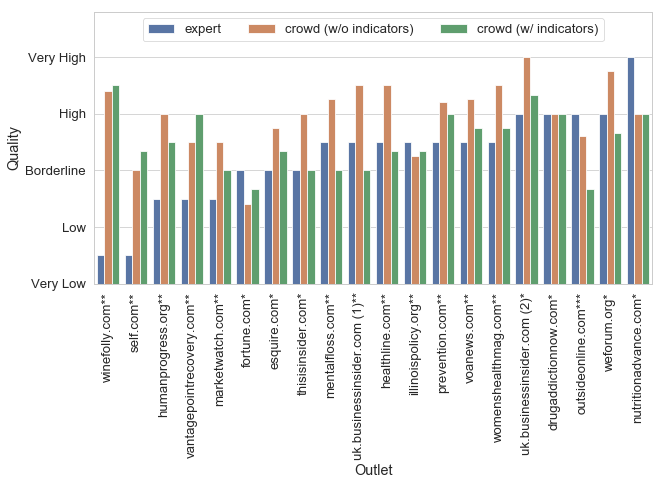

In [438]:
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(hue='Rated by', y='Quality', x='Outlet', data=df, ax=ax)
ax.set_yticks(ticks=[0, 1, 2, 3, 4, 4.8])
ax.set_yticklabels(['Very Low', 'Low', 'Borderline', 'High', 'Very High', ''])
plt.xticks(rotation=90)
plt.legend(loc='upper center', ncol=3)
fig.savefig(figures+'a-t-c.pdf', bbox_inches='tight')